<a href="https://colab.research.google.com/github/joyceee916/ATMS-597-SP-2020-Project-4/blob/master/Project4_Joyce_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()

In [29]:
cd /content/drive/My Drive/ATMS 597/Project4

/content/drive/My Drive/ATMS 597/Project4


Importing KCMI Observational Data

In [30]:
KCMI_daily = pd.read_csv("KCMI_daily_format.csv", parse_dates=True, index_col='Date')
KCMI_daily.rename(columns={'TMAX(C)': 'TMAX_Obs', 'TMIN(C)': 'TMIN_Obs', 'WMAX(M/s)': 'WMAX_Obs', 'PREC(mm}': 'RTOT_Obs'}, inplace = True)
KCMI_daily.dropna(inplace=True)
KCMI_daily.index = KCMI_daily.index + pd.DateOffset(hours=12)  
KCMI_daily = KCMI_daily.rename_axis('Time')
KCMI_daily.head()

,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs
Time,,,,
2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0
2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0
2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0
2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0
2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0


GFS Daily Model 

In [31]:
GFS_daily = pd.read_csv("GFS_daily_2010_2019_test.csv", parse_dates=True, index_col='Time')
GFS_daily.drop(columns="Unnamed: 0", inplace=True)
GFS_daily.rename(columns={'TMAX': 'TMAX_GFS', 'TMIN': 'TMIN_GFS', 'WMAX': 'WMAX_GFS', 'RTOT': 'RTOT_GFS'}, inplace = True)
GFS_daily.dropna(inplace=True)
GFS_daily['month_sin'] = np.sin(GFS_daily.index.month*(2.*np.pi/24))
GFS_daily['month_cos'] = np.cos(GFS_daily.index.month*(2.*np.pi/24))
GFS_daily.head()

,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,month_sin,month_cos
Time,,,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05,0.258819,0.965926
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,0.258819,0.965926
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,0.258819,0.965926
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,0.258819,0.965926
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,0.258819,0.965926


GFS Surface Data

In [0]:
GFS_surface = pd.read_csv("GFS_Sfc_new.csv", parse_dates=True, index_col='Time')
GFS_surface.rename(columns={'DWPC': 'DWPC_Surf', 'HCLD': 'HCLD_Surf', 'LCLD': 'LCLD_Surf', 'MCLD': 'MCLD_Surf',
                            'PRCP': 'PRCP_Surf', 'PRES': 'PRES_Surf', 'TMPC': 'TMPC_Surf', 'UWND': 'UWND_Surf',
                            'VWND': 'VWND_Surf', 'WSPD': 'WSPD_Surf'}, inplace = True)
GFS_surface.dropna(inplace=True)
GFS_surface.head(10)
GFS_surface.replace({9999.0: np.nan}, inplace=True)
GFS_surface.replace({-9999.0: np.nan}, inplace=True)

In [9]:
# shift data back 6 hours and resample by day 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = -6)
GFS_surface = GFS_surface.resample('24H').max()

# shift the data forward 12 hours for ease of merging with other datasets 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = 12)
GFS_surface.head(10)

,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf
Time,,,,,,,,,,
2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933
2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217
2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380
2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068
2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733
2010-01-07 12:00:00,-6.13,100.0,100.0,100.0,2.06,992.5,-5.46,5.3,2.4,6.888396
2010-01-08 12:00:00,-4.15,34.0,100.0,6.0,0.63,1000.0,-3.46,5.3,-2.0,8.645230
2010-01-09 12:00:00,-10.81,0.0,100.0,0.0,0.02,1004.9,-8.56,2.9,-2.4,4.441846
2010-01-10 12:00:00,-9.09,80.0,3.0,62.0,0.00,1005.7,-7.26,4.3,5.7,6.824954


GFS Profile Data

In [11]:
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)
h=GFS_profile.DWPC.str.strip('[|]|,').values

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level)
    GFS_profile[new_col_name]=list
GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0, 250.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').mean()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

,DWPC_925.0,DWPC_850.0,DWPC_700.0,DWPC_500.0,DWPC_250.0,HGHT_925.0,HGHT_850.0,HGHT_700.0,HGHT_500.0,HGHT_250.0,TMPC_925.0,TMPC_850.0,TMPC_700.0,TMPC_500.0,TMPC_250.0,UWND_925.0,UWND_850.0,UWND_700.0,UWND_500.0,UWND_250.0,VWND_925.0,VWND_850.0,VWND_700.0,VWND_500.0,VWND_250.0
Time,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643
2010-01-03 12:00:00,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919
2010-01-04 12:00:00,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021
2010-01-05 12:00:00,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217
2010-01-06 12:00:00,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228


Combine Datasets

In [12]:
# Combine GFS daily and KCMI daily
df1 = pd.merge(GFS_daily.reset_index(), KCMI_daily.reset_index(), on='Time', how='inner')
df1.Time = pd.to_datetime(df1.Time)
df1['Year'] = df1.Time.dt.year
df1['D_TMAX'] = df1['TMAX_GFS']-df1['TMAX_Obs']
df1['D_TMIN'] = df1['TMIN_GFS']-df1['TMIN_Obs']
df1['D_WMAX'] = df1['WMAX_GFS']-df1['WMAX_Obs']
df1['D_RTOT'] = df1['RTOT_GFS']-df1['RTOT_Obs']
df1

,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,month_sin,month_cos,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT
0,2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05,2.588190e-01,0.965926,-11.111111,-16.666667,6.70560,0.0,2010,-0.148889,0.206667,0.618333,0.05
1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,2.588190e-01,0.965926,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00
2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,2.588190e-01,0.965926,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06
3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,2.588190e-01,0.965926,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17
4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,2.588190e-01,0.965926,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,2019-12-27 12:00:00,13.94,3.54,8.819297,2.73,1.224647e-16,-1.000000,6.111111,0.000000,6.70560,0.0,2019,7.828889,3.540000,2.113697,2.73
3572,2019-12-28 12:00:00,15.94,9.34,9.701546,11.58,1.224647e-16,-1.000000,13.333333,0.000000,10.28192,2.8,2019,2.606667,9.340000,-0.580374,8.78
3573,2019-12-29 12:00:00,7.24,-1.66,11.111256,2.57,1.224647e-16,-1.000000,15.000000,5.000000,10.28192,4.3,2019,-7.760000,-6.660000,0.829336,-1.73
3574,2019-12-30 12:00:00,-0.36,-2.26,8.769265,0.04,1.224647e-16,-1.000000,3.333333,-0.555556,11.62304,0.6,2019,-3.693333,-1.704444,-2.853775,-0.56


In [32]:
# Combine GFS Profile and GFS Surface 
df2 = pd.merge(GFS_surface.reset_index(), GFS_profile.reset_index(), on='Time', how='inner')
df2.Time = pd.to_datetime(df2.Time)
df2.head()

,Time,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0,DWPC_850.0,DWPC_700.0,DWPC_500.0,DWPC_250.0,HGHT_925.0,HGHT_850.0,HGHT_700.0,HGHT_500.0,HGHT_250.0,TMPC_925.0,TMPC_850.0,TMPC_700.0,TMPC_500.0,TMPC_250.0,UWND_925.0,UWND_850.0,UWND_700.0,UWND_500.0,UWND_250.0,VWND_925.0,VWND_850.0,VWND_700.0,VWND_500.0,VWND_250.0
0,2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643
1,2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919
2,2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021
3,2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217
4,2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228


In [33]:
# Combine two intermediate datasets into one feature matrix
features_df = pd.merge(df1.reset_index(), df2.reset_index(), on='Time', how='inner')
features_df.Time = pd.to_datetime(features_df.Time)
features_df.dropna(inplace=True)
features_df.head()

,index_x,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,month_sin,month_cos,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT,index_y,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0,DWPC_850.0,DWPC_700.0,DWPC_500.0,DWPC_250.0,HGHT_925.0,HGHT_850.0,HGHT_700.0,HGHT_500.0,HGHT_250.0,TMPC_925.0,TMPC_850.0,TMPC_700.0,TMPC_500.0,TMPC_250.0,UWND_925.0,UWND_850.0,UWND_700.0,UWND_500.0,UWND_250.0,VWND_925.0,VWND_850.0,VWND_700.0,VWND_500.0,VWND_250.0
0,1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,0.258819,0.965926,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00,0,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643,-25.221669,-31.631814,-42.343174,-49.713078,-68.190643
1,2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,0.258819,0.965926,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06,1,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919,-24.612461,-33.524255,-45.006084,-38.011418,-68.911919
2,3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,0.258819,0.965926,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17,2,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021,-19.773137,-24.218344,-25.096941,-42.369095,-68.447021
3,4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,0.258819,0.965926,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77,3,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217,-15.254223,-17.749616,-24.500529,-39.556158,-65.837217
4,5,2010-01-06 12:00:00,-5.46,-7.46,9.548298,7.10,0.258819,0.965926,-7.777778,-19.444444,3.57632,1.5,2010,2.317778,11.984444,5.971978,5.60,4,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228,-16.456283,-26.308794,-26.778580,-37.508100,-66.427228


In [0]:
# Split into training and test sets 
# Can change features 
x_train_all = features_df[features_df.Time.dt.year<2019]
x_test_all = features_df[features_df.Time.dt.year==2019]

y_train_all = features_df[features_df.Time.dt.year<2019]
y_test_all = features_df[features_df.Time.dt.year==2019]

Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt

**Linear Regression**

Max Temperature

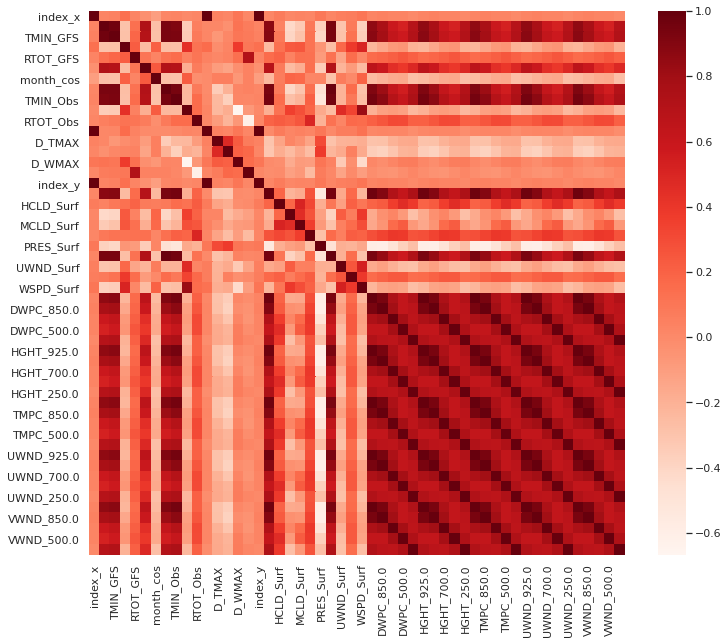

In [18]:
plt.figure(figsize=(12,10))
cor = features_df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [0]:
def lin_model_func(features, target):
    lin_model = LinearRegression()
    x_train = x_train_all[features]
    y_train = y_train_all[target]

    x_test = x_test_all[features]
    y_test = y_test_all[target]

    lin_model.fit(x_train, y_train)

    # Print parameters and plot - GFS Data
    print('Coefficients: \n', lin_model.coef_)
    print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, lin_model.predict(x_test))))

    print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

    return x_test, y_test, lin_model


Max Temperature

In [19]:
# Correlation with output variable 
cor_target = abs(cor['TMAX_Obs'])

relevant_features = cor_target[cor_target>0.80]
relevant_features

TMAX_GFS      0.932789
TMIN_GFS      0.929750
TMAX_Obs      1.000000
TMIN_Obs      0.941975
DWPC_Surf     0.933012
TMPC_Surf     0.983215
DWPC_925.0    0.910837
DWPC_850.0    0.815406
HGHT_925.0    0.910837
HGHT_850.0    0.815406
TMPC_925.0    0.910837
TMPC_850.0    0.815406
UWND_925.0    0.910837
UWND_850.0    0.815406
VWND_925.0    0.910837
VWND_850.0    0.815406
Name: TMAX_Obs, dtype: float64

In [38]:
features = ['TMAX_GFS', 'TMIN_Obs', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0', 'DWPC_850.0', 'HGHT_925.0', 'HGHT_850.0', 'TMPC_925.0', 'TMPC_850.0', 'UWND_925.0', 'UWND_850.0', 'VWND_925.0', 'VWND_850.0']
target = ['TMAX_Obs']

x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[ 5.50372615e-02  5.02972023e-02  2.29919672e-02  4.98329596e-04
   9.49736404e-01  2.21406011e-03 -8.30811341e-03  2.21406011e-03
  -8.30811341e-03  2.21406011e-03 -8.30811341e-03  2.21406011e-03
  -8.30811341e-03  2.21406011e-03 -8.30811341e-03]]
The Mean Absolute Error: 1.53 degrees celsius
The Median Absolute Error: 1.30 degrees celsius
The Root Mean Square Error: 1.97 degrees celsius 
Coefficient of determination: 0.97


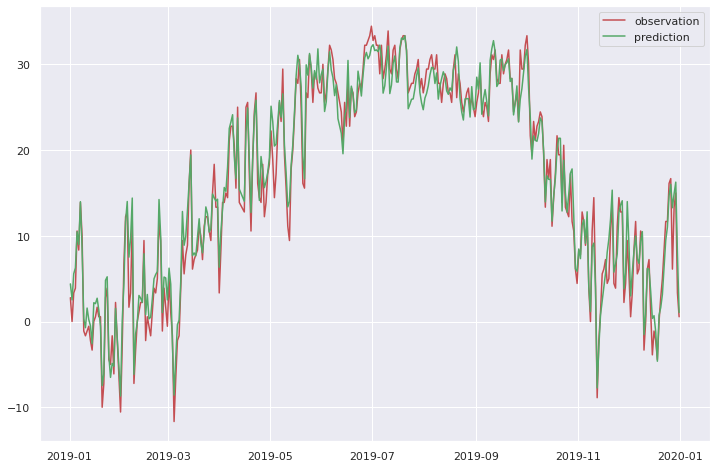

In [40]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, lin_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('linearregression.jpg')

Minimum Temperature

In [42]:
# Correlation with output variable 
cor_target = abs(cor['TMIN_Obs'])

relevant_features = cor_target[cor_target>0.80]
relevant_features

TMAX_GFS      0.911077
TMIN_GFS      0.927127
TMAX_Obs      0.941975
TMIN_Obs      1.000000
DWPC_Surf     0.950509
TMPC_Surf     0.954639
DWPC_925.0    0.951224
DWPC_850.0    0.876021
HGHT_925.0    0.951224
HGHT_850.0    0.876021
TMPC_925.0    0.951224
TMPC_850.0    0.876021
UWND_925.0    0.951224
UWND_850.0    0.876021
VWND_925.0    0.951224
VWND_850.0    0.876021
Name: TMIN_Obs, dtype: float64

In [43]:
features = ['TMAX_GFS', 'TMIN_GFS', 'TMAX_Obs', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0', 'DWPC_850.0', 'HGHT_925.0', 'HGHT_850.0', 'TMPC_925.0', 'TMPC_850.0', 'UWND_925.0', 'UWND_850.0', 'VWND_925.0', 'VWND_850.0']
target = ['TMIN_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[-0.00474308  0.23982924  0.06281258  0.03481845  0.23698709  0.07441879
   0.00592653  0.07441879  0.00592653  0.07441879  0.00592653  0.07441879
   0.00592653  0.07441879  0.00592653]]
The Mean Absolute Error: 2.00 degrees celsius
The Median Absolute Error: 1.63 degrees celsius
The Root Mean Square Error: 2.61 degrees celsius 
Coefficient of determination: 0.94


Maximum Wind Speed

In [44]:
# Correlation with output variable 
cor_target = abs(cor['WMAX_Obs'])

relevant_features = cor_target[cor_target>0.3]
relevant_features

TMAX_GFS     0.343447
TMIN_GFS     0.328572
WMAX_GFS     0.435622
WMAX_Obs     1.000000
D_WMAX       0.666938
LCLD_Surf    0.355628
UWND_Surf    0.469244
VWND_Surf    0.337364
WSPD_Surf    0.825063
Name: WMAX_Obs, dtype: float64

In [45]:
features = ['TMAX_GFS', 'TMIN_GFS', 'WMAX_GFS', 'PRES_Surf', 'WSPD_Surf', 'UWND_Surf', 'LCLD_Surf']
target = ['WMAX_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[ 0.00644651 -0.02363717  0.01970253 -0.03089589  0.9516659   0.02734911
   0.00109629]]
The Mean Absolute Error: 1.24 degrees celsius
The Median Absolute Error: 1.02 degrees celsius
The Root Mean Square Error: 1.59 degrees celsius 
Coefficient of determination: 0.71


Precipitation Accumulation

In [26]:
# Correlation with output variable 
cor_target = abs(cor['RTOT_Obs'])

relevant_features = cor_target[cor_target>0.26]
relevant_features

RTOT_Obs      1.000000
D_RTOT        0.610566
PRCP_Surf     0.502113
DWPC_700.0    0.315228
DWPC_500.0    0.305786
HGHT_700.0    0.315228
HGHT_500.0    0.305786
TMPC_700.0    0.315228
TMPC_500.0    0.305786
UWND_700.0    0.315228
UWND_500.0    0.305786
VWND_700.0    0.315228
VWND_500.0    0.305786
Name: RTOT_Obs, dtype: float64

In [47]:
features = ['PRCP_Surf', 'DWPC_700.0', 'DWPC_500.0', 'HGHT_700.0', 'HGHT_500.0', 'TMPC_700.0', 'TMPC_500.0', 'UWND_700.0', 'UWND_500.0', 'VWND_700.0', 'VWND_500.0']
target = ['RTOT_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[0.91589373 0.01010541 0.01055947 0.01010541 0.01055947 0.01010541
  0.01055947 0.01010541 0.01055947 0.01010541 0.01055947]]
The Mean Absolute Error: 2.32 degrees celsius
The Median Absolute Error: 1.18 degrees celsius
The Root Mean Square Error: 4.03 degrees celsius 
Coefficient of determination: 0.36


**Random Forest**

Maximum Temperature

In [1]:
# Create random forest regression model 
# some code adapted from (https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
from sklearn.ensemble import RandomForestRegressor 

features = ['TMAX_GFS', 'TMIN_GFS', 'WMAX_GFS', 'month_sin', 'month_cos', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0',
            'DWPC_850.0', 'HGHT_925.0', 'HGHT_850.0', 'TMPC_925.0', 'TMPC_850.0', 'UWND_925.0', 'UWND_850.0']
target = ['TMAX_Obs']

x_train = x_train_all[features]
y_train = y_train_all[target]

x_test = x_test_all[features]
y_test = y_test_all[target]

# TODO could create empty numpy arrays and then plot the effect of changing estimators and max features on the errors (4 metrics)
n_estimators = [1000]
max_features = [5]
for n in n_estimators: 
    for m in max_features: 
        # Train the model 
        rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
        rf_model.fit(x_train, y_train)

        # Print parameters and plot
        print("# of trees =", n)
        print("Max features = ", m)
        print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
        print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))


NameError: ignored

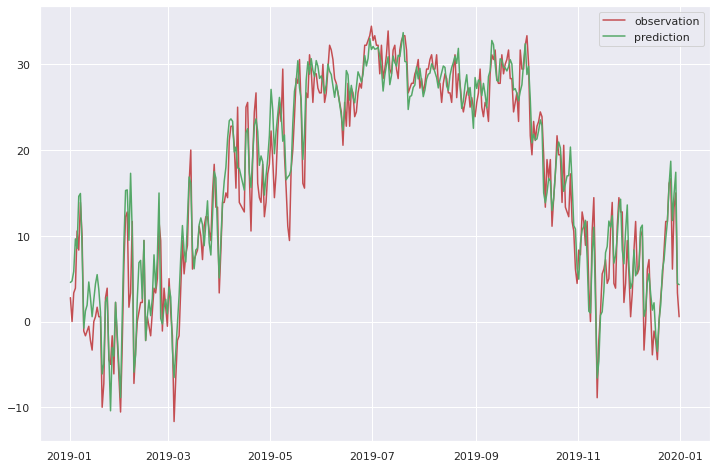

In [0]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, rf_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('randomforest.jpg')
plt.show()

Minimum Temperature

In [0]:
# Create random forest regression model 
# some code adapted from (https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
from sklearn.ensemble import RandomForestRegressor 

features = ['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0', 'DWPC_850.0', 'HGHT_925.0', 'HGHT_850.0', 'TMPC_925.0', 'TMPC_850.0', 'UWND_925.0', 'UWND_850.0', 'VWND_925.0', 'VWND_850.0']
target = ['TMIN_Obs']

x_train = x_train_all[features]
y_train = y_train_all[target]

x_test = x_test_all[features]
y_test = y_test_all[target]

# TODO could create empty numpy arrays and then plot the effect of changing estimators and max features on the errors (4 metrics)
n_estimators = [100, 200, 300]
max_features = [3, 4, 4]
for n in n_estimators: 
    for m in max_features: 
        # Train the model 
        rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
        rf_model.fit(x_train, y_train)

        # Print parameters and plot
        print("# of trees =", n)
        print("Max features = ", m)
        print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
        print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  3
The Mean Absolute Error: 1.47 degrees celsius
The Median Absolute Error: 1.15 degrees celsius
The Root Mean Square Error: 1.95 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.40 degrees celsius
The Median Absolute Error: 1.09 degrees celsius
The Root Mean Square Error: 1.88 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.40 degrees celsius
The Median Absolute Error: 1.10 degrees celsius
The Root Mean Square Error: 1.87 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  3
The Mean Absolute Error: 1.44 degrees celsius
The Median Absolute Error: 1.17 degrees celsius
The Root Mean Square Error: 1.92 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.42 degrees celsius
The Median Absolute Error: 1.12 degrees celsius
The Root Mean Square Error: 1.88 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.41 degrees celsius
The Median Absolute Error: 1.06 degrees celsius
The Root Mean Square Error: 1.89 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  3
The Mean Absolute Error: 1.44 degrees celsius
The Median Absolute Error: 1.11 degrees celsius
The Root Mean Square Error: 1.92 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.40 degrees celsius
The Median Absolute Error: 1.12 degrees celsius
The Root Mean Square Error: 1.88 degrees celsius 
Coefficient of determination: 0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.41 degrees celsius
The Median Absolute Error: 1.11 degrees celsius
The Root Mean Square Error: 1.88 degrees celsius 
Coefficient of determination: 0.97
[(0.3109, 'TMPC_Surf'), (0.2175, 'DWPC_Surf'), (0.0975, 'UWND_925.0'), (0.0848, 'HGHT_925.0'), (0.0795, 'TMPC_925.0'), (0.0788, 'DWPC_925.0'), (0.0696, 'VWND_925.0'), (0.0321, 'TMIN_GFS'), (0.0163, 'TMAX_GFS'), (0.0029, 'DWPC_850.0'), (0.0027, 'VWND_850.0'), (0.0027, 'HGHT_850.0'), (0.0026, 'UWND_850.0'), (0.002, 'TMPC_850.0')]


Wind Speed

In [0]:
# Create random forest regression model 
from sklearn.ensemble import RandomForestRegressor 

features = ['TMAX_GFS', 'TMIN_GFS', 'WMAX_GFS', 'PRES_Surf', 'WSPD_Surf', 'UWND_Surf']
target = ['WMAX_Obs']

x_train = x_train_all[features]
y_train = y_train_all[target]

x_test = x_test_all[features]
y_test = y_test_all[target]

# TODO could create empty numpy arrays and then plot the effect of changing estimators and max features on the errors (4 metrics)
n_estimators = [100, 200, 300]
max_features = [3, 4, 4]
for n in n_estimators: 
    for m in max_features: 
        # Train the model 
        rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
        rf_model.fit(x_train, y_train)

        # Print parameters and plot
        print("# of trees =", n)
        print("Max features = ", m)
        print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
        print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  3
The Mean Absolute Error: 1.67 degrees celsius
The Median Absolute Error: 1.40 degrees celsius
The Root Mean Square Error: 2.14 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.66 degrees celsius
The Median Absolute Error: 1.40 degrees celsius
The Root Mean Square Error: 2.13 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.67 degrees celsius
The Median Absolute Error: 1.39 degrees celsius
The Root Mean Square Error: 2.13 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  3
The Mean Absolute Error: 1.67 degrees celsius
The Median Absolute Error: 1.38 degrees celsius
The Root Mean Square Error: 2.14 degrees celsius 
Coefficient of determination: 0.48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.65 degrees celsius
The Median Absolute Error: 1.35 degrees celsius
The Root Mean Square Error: 2.12 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.66 degrees celsius
The Median Absolute Error: 1.40 degrees celsius
The Root Mean Square Error: 2.12 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  3
The Mean Absolute Error: 1.67 degrees celsius
The Median Absolute Error: 1.35 degrees celsius
The Root Mean Square Error: 2.13 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.66 degrees celsius
The Median Absolute Error: 1.40 degrees celsius
The Root Mean Square Error: 2.13 degrees celsius 
Coefficient of determination: 0.49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.66 degrees celsius
The Median Absolute Error: 1.40 degrees celsius
The Root Mean Square Error: 2.13 degrees celsius 
Coefficient of determination: 0.49
[(0.4, 'WSPD_Surf'), (0.2066, 'PRES_Surf'), (0.1226, 'WMAX_GFS'), (0.1134, 'TMAX_GFS'), (0.0808, 'UWND_Surf'), (0.0766, 'TMIN_GFS')]


Precipitation

In [0]:
# Create random forest regression model 
from sklearn.ensemble import RandomForestRegressor 

features = ['D_RTOT', 'PRCP_Surf', 'DWPC_700.0', 'DWPC_500.0', 'HGHT_700.0', 'HGHT_500.0', 'TMPC_700.0', 'TMPC_500.0', 'UWND_700.0', 'UWND_500.0', 'VWND_700.0', 'VWND_500.0']
target = ['RTOT_Obs']

x_train = x_train_all[features]
y_train = y_train_all[target]

x_test = x_test_all[features]
y_test = y_test_all[target]

# TODO could create empty numpy arrays and then plot the effect of changing estimators and max features on the errors (4 metrics)
n_estimators = [100, 200, 300]
max_features = [3, 4, 4]
for n in n_estimators: 
    for m in max_features: 
        # Train the model 
        rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
        rf_model.fit(x_train, y_train)

        # Print parameters and plot
        print("# of trees =", n)
        print("Max features = ", m)
        print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
        print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
        print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  3
The Mean Absolute Error: 1.16 degrees celsius
The Median Absolute Error: 0.40 degrees celsius
The Root Mean Square Error: 2.33 degrees celsius 
Coefficient of determination: 0.79


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.05 degrees celsius
The Median Absolute Error: 0.38 degrees celsius
The Root Mean Square Error: 2.10 degrees celsius 
Coefficient of determination: 0.83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 100
Max features =  4
The Mean Absolute Error: 1.02 degrees celsius
The Median Absolute Error: 0.32 degrees celsius
The Root Mean Square Error: 2.06 degrees celsius 
Coefficient of determination: 0.83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  3
The Mean Absolute Error: 1.12 degrees celsius
The Median Absolute Error: 0.39 degrees celsius
The Root Mean Square Error: 2.22 degrees celsius 
Coefficient of determination: 0.81


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.02 degrees celsius
The Median Absolute Error: 0.34 degrees celsius
The Root Mean Square Error: 2.07 degrees celsius 
Coefficient of determination: 0.83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 200
Max features =  4
The Mean Absolute Error: 1.03 degrees celsius
The Median Absolute Error: 0.36 degrees celsius
The Root Mean Square Error: 2.08 degrees celsius 
Coefficient of determination: 0.83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  3
The Mean Absolute Error: 1.12 degrees celsius
The Median Absolute Error: 0.43 degrees celsius
The Root Mean Square Error: 2.22 degrees celsius 
Coefficient of determination: 0.81


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.02 degrees celsius
The Median Absolute Error: 0.34 degrees celsius
The Root Mean Square Error: 2.08 degrees celsius 
Coefficient of determination: 0.83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# of trees = 300
Max features =  4
The Mean Absolute Error: 1.03 degrees celsius
The Median Absolute Error: 0.33 degrees celsius
The Root Mean Square Error: 2.09 degrees celsius 
Coefficient of determination: 0.83
[(0.6784, 'D_RTOT'), (0.04, 'DWPC_700.0'), (0.0361, 'TMPC_700.0'), (0.0348, 'VWND_700.0'), (0.0347, 'HGHT_700.0'), (0.034, 'UWND_700.0'), (0.03, 'VWND_500.0'), (0.0292, 'TMPC_500.0'), (0.0287, 'DWPC_500.0'), (0.0279, 'UWND_500.0'), (0.0262, 'HGHT_500.0'), (0.0, 'PRCP_Surf')]
